# Машинное обучение, ФКН ВШЭ

## Практическое задание 4. Классификация

### Общая информация
Дата выдачи: 16.11.2024

Мягкий дедлайн: 28.11.2024

Жесткий дедлайн: 02.12.2024

### О задании

В этом задании вы:
- ознакомитесь с тем, что происходит "внутри" метода опорных векторов и логистической регрессии
- познакомитесь с калибровкой вероятности
- изучите методы трансформации переменных и методы отбора признаков
- попробуете оценить экономический эффект модели

----

#### Самостоятельная оценка результатов

Для удобства проверки, исходя из набора решенных задач, посчитайте свою максимальную оценку.

**Оценка**:

### Оценивание и штрафы

Каждая из задач имеет определенную «стоимость» (указана в скобках около задачи). Максимально допустимая оценка за работу — 10 баллов.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов (подробнее о плагиате см. на странице курса). Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

Неэффективная реализация кода может негативно отразиться на оценке.

### Формат сдачи

Для сдачи задания переименуйте получившийся файл *.ipynb в соответствии со следующим форматом: homework-practice-04-linclass-__Username__.ipynb, где Username — ваша фамилия и имя на латинице именно в таком порядке (например, homework-practice-04-linclass-__IvanovIvan__.ipynb).

# Часть 1. SVM, LR и калибровка вероятностей (2 балла + 0.5 бонус)

In [1]:
import numpy as np
import pandas as pd
# import polars as pl
import matplotlib.pyplot as plt
%matplotlib inline

pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)
# pl.Config().set_tbl_rows(100)
# pl.Config().set_tbl_cols(100)

#### __Задание 1.1  Сравнение методов__ (0.5 балла)



Сгенерируем синтетические данные.

In [2]:
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

# фиксируем random_state для воспроизводимости результатов
X, y = make_classification(
    n_samples=10000, n_features=10, n_informative=5, n_redundant=5, random_state=42
)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

__Случайный классификатор__

Для начала зададим самую простую модель, которая на каждом объекте выдаёт случайный ответ. По тестовой выборке вычислим AUC-ROC, AUC-PR.

In [3]:
from sklearn.dummy import DummyClassifier
random_classifier = DummyClassifier(strategy='uniform', random_state=42).fit(X_train, y_train)
y_random = random_classifier.predict_proba(X_test)[:,1]
y_random

array([0.5, 0.5, 0.5, ..., 0.5, 0.5, 0.5])

**Вопрос:** решаем задачу бинарной классификации, но y\_random содержит какие-то дробные числа, а не 0/1. Почему?



**Ответ**: Классификатор выдает вероятности классов, так как все объекты для дамми классификатора идентичны, он выдает для них одинаковые ответы.

*Ниже приведен **пример** работы* со встроенными функциями `sklearn` для отрисовки ROC и PR кривых, сохранения метрик. Пайплайн можно изменять как вам удобно.

In [4]:
from sklearn.metrics import average_precision_score

from sklearn.metrics import precision_recall_curve
from sklearn.metrics import PrecisionRecallDisplay

from sklearn.metrics import roc_auc_score
from sklearn.metrics import RocCurveDisplay

Random Classifier metrics
AUC-PR: 0.5057
AUC-ROC: 0.5000


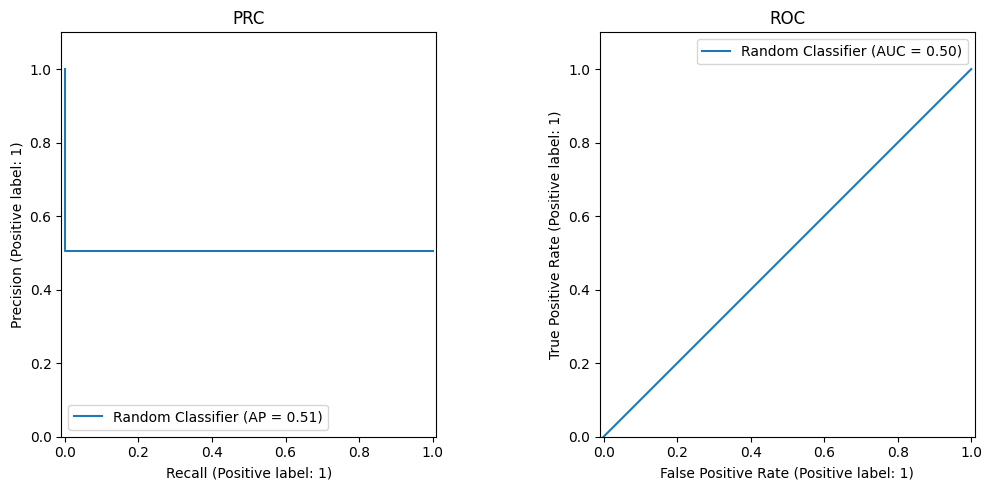

In [5]:
def depict_pr_roc(y_true, y_pred, classifier_name='Some Classifier', ax=None):
    if ax is None:
        fig, ax = plt.subplots(1, 2, figsize=(11, 5))

    print(classifier_name, 'metrics')
    PrecisionRecallDisplay.from_predictions(y_true, y_pred, ax=ax[0], name=classifier_name)
    print('AUC-PR: %.4f' % average_precision_score(y_true, y_pred))
    ax[0].set_title("PRC")
    ax[0].set_ylim(0, 1.1)

    RocCurveDisplay.from_predictions(y_true, y_pred, ax=ax[1], name=classifier_name)
    print('AUC-ROC: %.4f' % roc_auc_score(y_true, y_pred))
    ax[1].set_title("ROC")
    ax[1].set_ylim(0, 1.1)

    plt.tight_layout()
    plt.legend()


depict_pr_roc(y_test, y_random, 'Random Classifier')

In [6]:
# dataframe для сравнения
# методов классификации по метрикам
df_metrics = pd.DataFrame(
    columns=['auc_pr', 'roc_auc_score', 'reg_const']
)
precision, recall, _ = precision_recall_curve(y_test, y_random)
# добавление очередной строки с характеристиками метода
df_metrics.loc['Random Classifier'] = [
      average_precision_score(y_test, y_random),
      roc_auc_score(y_test, y_random),
      0,
]

# по аналогии результаты следующих экспериментов можно будет собрать в табличку
df_metrics

,auc_pr,roc_auc_score,reg_const
Random Classifier,0.505667,0.5,0.0


__Support Vector Machine (Linear Kernel)__

Обучите метод опорных векторов.

Подберите параметр регуляризации `C` с точки зрения AUC-PR (можете воспользоваться кросс-валидацией или отделить валидационную выборку от обучающей).


In [7]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [8]:
from sklearn.svm import LinearSVC
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import average_precision_score as auc_pr

errors = []
auc_prs = []
# C > 0
possible_c = np.hstack([1, np.logspace(-1, 2, 10)])
for C in possible_c:
    model = LinearSVC(dual=True, C=C, max_iter=10000).fit(X_train, y_train)
    print(model)
    auc_prs.append(auc_pr(model.predict(X_val), y_val))
    error = mse(model.predict(X_val), y_val)
    errors.append(error)

LinearSVC(dual=True, max_iter=10000)
LinearSVC(C=0.1, dual=True, max_iter=10000)
LinearSVC(C=0.21544346900318834, dual=True, max_iter=10000)
LinearSVC(C=0.46415888336127786, dual=True, max_iter=10000)
LinearSVC(dual=True, max_iter=10000)
LinearSVC(C=2.1544346900318834, dual=True, max_iter=10000)


/home/sacr1ficerq/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


LinearSVC(C=4.6415888336127775, dual=True, max_iter=10000)


/home/sacr1ficerq/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


LinearSVC(C=10.0, dual=True, max_iter=10000)


/home/sacr1ficerq/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


LinearSVC(C=21.54434690031882, dual=True, max_iter=10000)


/home/sacr1ficerq/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


LinearSVC(C=46.41588833612777, dual=True, max_iter=10000)
LinearSVC(C=100.0, dual=True, max_iter=10000)


/home/sacr1ficerq/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


In [9]:
best_c_svm = possible_c[np.argmax(auc_prs)]
best_c_svm

21.54434690031882

  На тестовой части:
  - постройте ROC и PR кривые,
  - посчитайте AUC-ROC, AUC-PR

In [10]:
y_pred_svm = LinearSVC(dual=True, C=best_c_svm, max_iter=3000).fit(X_train, y_train).decision_function(X_test)

/home/sacr1ficerq/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


svm, LinearSVC metrics
AUC-PR: 0.8212
AUC-ROC: 0.8461


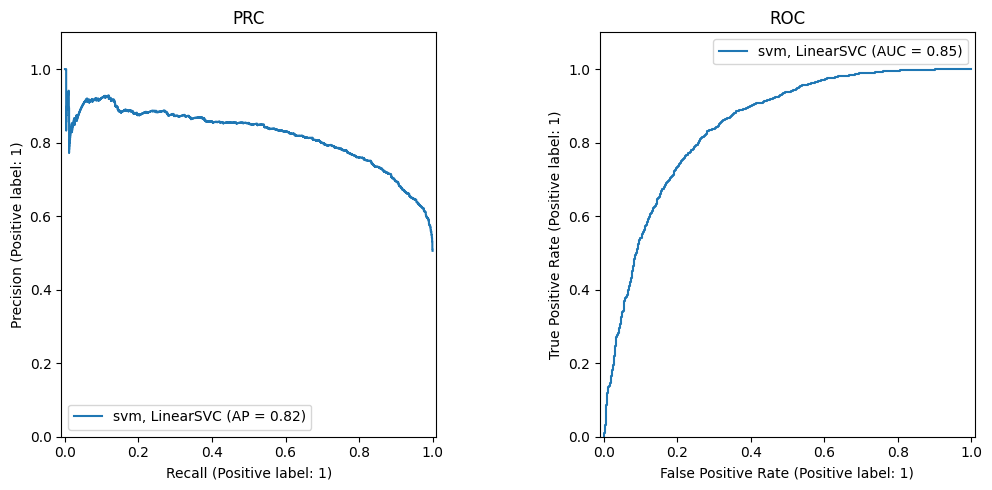

In [11]:
depict_pr_roc(y_test, y_pred_svm, 'SVM')

Проанализируйте, как себя ведут обе кривые:
- Что происходит при увеличении порога? Как бы вы это проинтерпретировали?
- Монотонные ли кривые? Как вы это объясните?

Сравните AUC-ROC и AUC-PR для вашей модели с этими же метриками для случайного классификатора.

In [12]:
precision, recall, _ = precision_recall_curve(y_test, y_pred_svm)
# добавление очередной строки с характеристиками метода
df_metrics.loc['SVM with best C'] = [
      average_precision_score(y_test, y_pred_svm),
      roc_auc_score(y_test, y_pred_svm),
      best_c_svm,
]

# по аналогии результаты следующих экспериментов можно будет собрать в табличку
df_metrics

,auc_pr,roc_auc_score,reg_const
Random Classifier,0.505667,0.500000,0.000000
SVM with best C,0.821150,0.846096,21.544347


__Logistic Regression__


Аналогичное задание для логистической регрессии с L2 регуляризатором:


*   подберите гиперпараметр C, используя метрику AUC-PR
*   нарисуйте ROC, PR кривые для тестовой части
*   выведите метрики для тестовых данных и сравните их с результатами случайного классификатора



In [13]:
from sklearn.linear_model import LogisticRegression

errors = []
auc_prs = []
# C > 0
possible_c = np.logspace(0, 4, 10)
for C in possible_c:
    model = LogisticRegression(penalty='l2', C=C, max_iter=5000).fit(X_train, y_train)
    print(model)
    auc_prs.append(auc_pr(model.predict(X_val), y_val))
    error = mse(model.predict(X_val), y_val)
    errors.append(error)

LogisticRegression(max_iter=5000)
LogisticRegression(C=2.7825594022071245, max_iter=5000)
LogisticRegression(C=7.742636826811269, max_iter=5000)
LogisticRegression(C=21.544346900318832, max_iter=5000)
LogisticRegression(C=59.94842503189409, max_iter=5000)
LogisticRegression(C=166.81005372000593, max_iter=5000)
LogisticRegression(C=464.15888336127773, max_iter=5000)
LogisticRegression(C=1291.5496650148827, max_iter=5000)
LogisticRegression(C=3593.813663804626, max_iter=5000)
LogisticRegression(C=10000.0, max_iter=5000)


In [14]:
best_c_logreg = possible_c[np.argmax(auc_prs)]
best_c_logreg

1.0

Нарисуйте ROC, PR кривые для тестовой части для всех 3 классификаторов на одном графике

LogReg metrics
AUC-PR: 0.8303
AUC-ROC: 0.8479


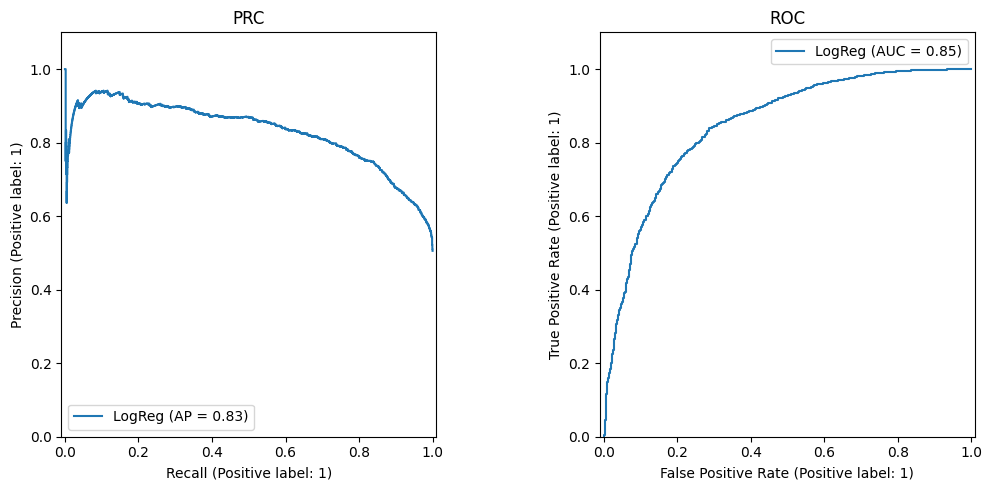

In [15]:
y_pred_logreg = LogisticRegression(penalty='l2', C=best_c_logreg, max_iter=5000).fit(X_train, y_train).predict_proba(X_test)[:, 1]
depict_pr_roc(y_test, y_pred_logreg, 'LogReg')

Random Classifier metrics
AUC-PR: 0.5057
AUC-ROC: 0.5000
svm, LinearSVC metrics
AUC-PR: 0.8212
AUC-ROC: 0.8461
LogReg metrics
AUC-PR: 0.8303
AUC-ROC: 0.8479


/tmp/ipykernel_69552/3082879020.py:16: UserWarning: The figure layout has changed to tight
  plt.tight_layout()
/tmp/ipykernel_69552/3082879020.py:16: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


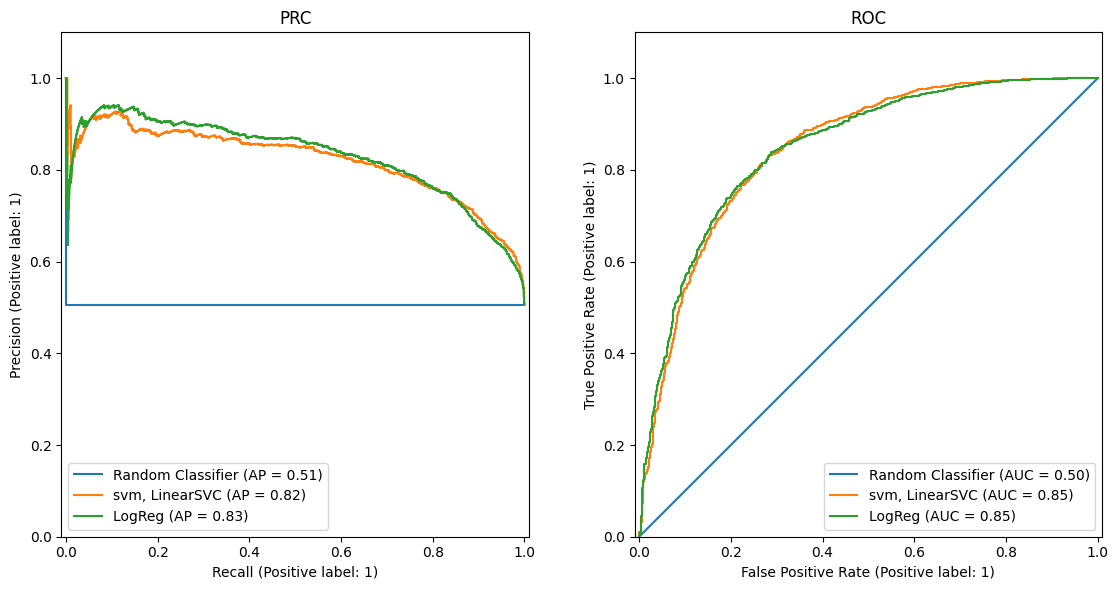

In [16]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

depict_pr_roc(y_test, y_random, 'Random Classifier', ax=ax)
depict_pr_roc(y_test, y_pred_svm, 'SVM', ax=ax)
depict_pr_roc(y_test, y_pred_logreg, 'LogReg', ax=ax)

**Вопрос:** Сравните результаты LR и SVM с точки зрения всех вычисленных критериев качества, объясните различия (если они есть).



**Ответ:** Оба метода дают сравнимые результаты, но Логистическая Регрессия обучается на неколько порядков быстрее, так что я бы предпочел ее.

#### __Задание 1.2. Визуализация в подходах SVM, LR__ (0.5 балла)



В названии метода опорных векторов присутствуют некоторые "опорные векторы". По сути, это объекты из обучающей выборки, которые задали положение разделяющей гиперплоскости.

* Сгенерируйте синтетические данные с помощью `make_classification` __с 2 признаками__, обучите на нём метод опорных векторов. Не забудьте зафиксировать seed для воспроизводимости

* Визуализируйте разделяющую прямую, все объекты и выделите опорные векторы. Ниже есть шаблоны, можете воспользоваться ими, либо написать своё

In [18]:
X, y = make_classification(n_samples=10000, n_features=2, n_informative=2, n_redundant=0, random_state=42)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [21]:
from sklearn.svm import SVC
model = SVC(kernel='linear', C=best_c_svm)
model.fit(X_train, y_train)

SVC(C=21.54434690031882, kernel='linear')

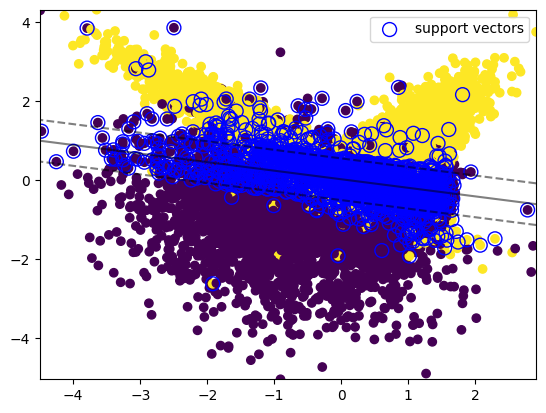

In [26]:
def plot_svm_2D(X, y, model,  plot_support=True):

    # создали сетку
    xx = np.linspace(X[:,0].min(), X[:,0].max(), 30)
    yy = np.linspace(X[:,1].min(), X[:,1].max(), 30)
    YY, XX = np.meshgrid(yy, xx)
    xy = np.vstack([XX.ravel(), YY.ravel()]).T

    # Ответы модели для сетки для отрисовки разделяющей прямой
    Z = model.decision_function(xy).reshape(XX.shape)

    plt.contour(XX, YY, Z, colors='k', levels=[-1, 0, 1], alpha=0.5, linestyles=['--', '-', '--'])

    # Отрисовали выборку
    plt.scatter(X[:, 0], X[:, 1], c=y)

    # Отрисовали опорные векторы
    if plot_support:
        plt.scatter(
            # your code here
            model.support_vectors_[:, 0],
            model.support_vectors_[:, 1],
            label='support vectors',
            s=100,
            linewidth=1,
            edgecolor="blue",
            facecolors='none'
        )

    plt.legend()

plot_svm_2D(X, y, model)

**Вопрос:** какие объекты выделяются как "опорные"?



**Ответ:** Ошибки и векторы на разделяющей прямой.

В отличие от метода опорных векторов, логистическая регрессия не пытается построить разделяющую гиперплоскость с максимальным отступом, а приближает в каждой точке пространства объектов вероятность положительных ответов $p(y=+1|x)$. Попробуйте нарисовать это распределение на плоскости, не забудьте отметить на ней все объекты.

In [27]:
model = LogisticRegression(C=best_c_logreg)
model.fit(X_train, y_train)

LogisticRegression()

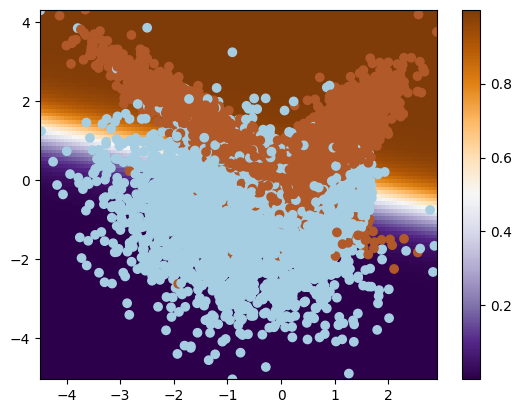

In [30]:
def plot_logreg_2D(X, y, model):

    # создали сетку
    xx = np.linspace(X[:,0].min(), X[:,0].max(), 100)
    yy = np.linspace(X[:,1].min(), X[:,1].max(), 100)
    YY, XX = np.meshgrid(yy, xx)
    xy = np.vstack([XX.ravel(), YY.ravel()]).T

    # Ответы модели для сетки для отрисовки распределения
    Z = model.predict_proba(xy)[:,1]
    Z = Z.reshape((xx.shape[0], -1)).T

    image = plt.imshow(
        Z,
        interpolation='nearest',
        extent=(xx.min(), xx.max(), yy.min(), yy.max()),
        aspect='auto',
        origin='lower',
        cmap=plt.cm.PuOr_r
    )

    #Отрисовали выборку
    plt.scatter(
        X[:, 0], 
        X[:, 1], 
        c=y,
        cmap=plt.cm.Paired
    )

    plt.colorbar(image)

plot_logreg_2D(X, y, model)

**Вопрос:** Как на картинке визуализирована область, где модель не уверена ($p(y=+1|x) = 0.5$)? Как это обосновать теоритечески?



**Ответ:** Это белая прямая - область, где модель равно оценивает вероятность обоих классов.

#### __Задание 2. Калибровка вероятностей__ (1 балл)



Перейдём к оценке качества выдаваемых алгоритмами вероятностей. Начнём с калибровочных кривых.

Допустим, алгоритм возвращает некоторые числа от нуля до единицы. Хорошо ли они оценивают вероятность?

Хорошо откалиброванный  классификатор должен выдавать значения так, чтобы среди образцов, для которых он дал значение, близкое к $\alpha$, примерно $\alpha * 100 \%$ фактически принадлежали к положительному классу. (Например, если классификатор выдает 0.3 для некоторых, то 30% из них должны принадлежать классу 1)

Для построения калибровочной криовой используем следующий алгоритм:

Разобьем отрезок $[0, 1]$ на несколько маленьких отрезков одинаковой длины.

Рассмотрим $i$-й отрезок с границами $[a_i, b_i]$ и предсказания $p_1, p_2, \dots, p_k$, которые попали в него. Пусть им соответствуют истинные ответы $y_1, y_2, \dots, y_k$. Если алгоритм выдает корректные вероятности, то среди этих истинных ответов должно быть примерно $(a_i + b_i) / 2$ единиц. Иными словами, если нарисовать кривую, у которой по оси X отложены центры отрезков, а по оси Y — доли единичных ответов этих в отрезках, то она должна оказаться диагональной.

Ниже приведена функция, которая должна рисовать такие кривые. В ней допущено две ошибки — найдите и исправьте их.

In [53]:
def plot_calibration_curve(y_test, preds):
    bin_middle_points = []
    bin_real_ratios = []
    n_bins = 10
    for i in range(n_bins):
        l = 1.0 / n_bins * i
        r = 1.0 / n_bins * (i + 1)
        bin_middle_points.append((l + r) / 2)
        bin_real_ratios.append(np.mean(y_test[(preds >= l) & (preds < r)] == 1))
    # plt.figure(figsize=(6,6))
    plt.plot(bin_middle_points, bin_real_ratios)
    plt.ylim([-0.05, 1.05])
    plt.grid()

Сгенерируйте синтетические данные аналогично использованным в самом первом задании. Постройте калибровочные кривые на тестовой части для логистической регрессии и метода опорных векторов (не забудьте перевести его предсказания в $[0;1]$).

Отрисуйте калибровочную кривую идеально откалиброванной модели (диагональ)

In [32]:
# your code here
X, y = make_classification(
    n_samples=10000, n_features=10, n_informative=5, n_redundant=5, random_state=42
)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [50]:
logreg = LogisticRegression(C=best_c_logreg)
logreg.fit(X_train, y_train)
logreg_pred = logreg.predict_proba(X_test)[:, 1]

svm = SVC(kernel='linear', C=best_c_svm, probability=True)
svm.fit(X_train, y_train)
svm_pred = (svc.decision_function(X_test) - np.min(X_test)) / (np.max(X_test) - np.min(X_test))

ideal_probs = np.linspace(0, 1, len(y_test))

<Figure size 600x600 with 0 Axes>

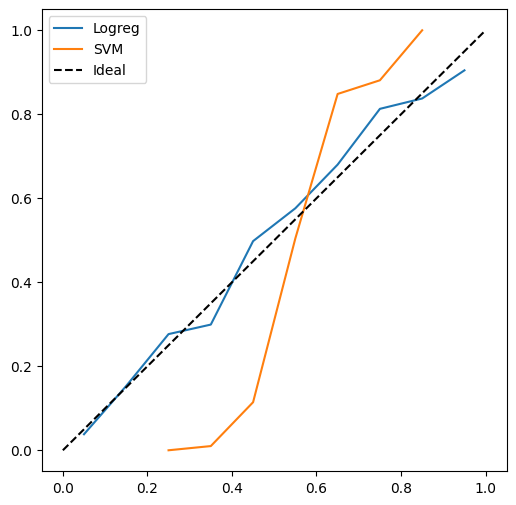

In [61]:
plt.figure(figsize=(6,6))
plot_calibration_curve(y_test, logreg_pred)
plot_calibration_curve(y_test, svm_pred)
plt.plot(ideal_probs, ideal_probs, linestyle='--', color='black')
plt.legend(['Logreg', 'SVM', 'Ideal'])
plt.show()

**Вопрос**: хорошо ли откалиброваны кривые для SVM, логистической регрессии? Подумайте, как это следует из вида кривой

**Ответ:** На графике видно, что Логистическая Регрессия откалибрована ощутимо лучше.

Из формальных способов в этом убедиться есть знакомый вам LogLoss, который напрямую оценивает вероятности,
$$\text{LogLoss} = -\frac{1}{N}\sum_{i} \sum_{k \in {0. 1}}\log p_k[y_i = k]$$
а так же BrierScore, который подсчитывает отклонение между получившейся вероятностью и реальным значением таргета.
$$\text{BrierScore} = \frac{1}{N}\sum_{i} (p_i - y_i)^2$$
Посмотрите на них тоже и сделайте вывод

In [73]:
from sklearn.metrics import log_loss, brier_score_loss

print(f'LogLoss    LogReg:\t{log_loss(y_test, logreg_pred): 0.2f}')
print(f'LogLoss    SVM:\t\t{log_loss(y_test, svm_pred): 0.2f}')

print(f'BrierScore LogrReg:\t{brier_score_loss(y_test, logreg_pred): 0.2f}')
print(f'BrierScore SVM:\t\t{brier_score_loss(y_test, svm_pred): 0.2f}')

LogLoss    LogReg:	 0.49
LogLoss    SVM:		 0.61
BrierScore LogrReg:	 0.16
BrierScore SVM:		 0.21


Как мы выдим обе ошибки у Логистической Регрессии значительно меньше, что подтверждает наше наблюдение.

Изучите распределение ответов классификаторов при помощи гистограмм

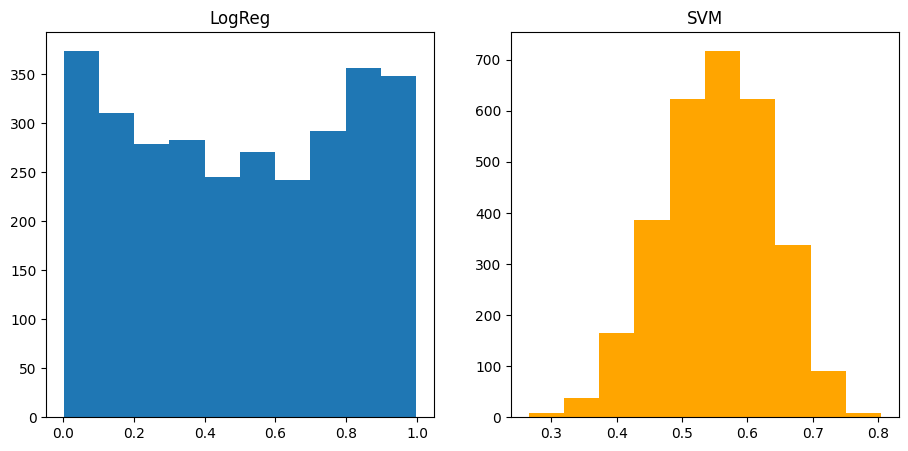

In [77]:
fig, ax = plt.subplots(1, 2, figsize=(11, 5))

ax[0].hist(logreg_pred, bins=10)
ax[0].set_title("LogReg")

ax[1].hist(svm_pred, bins=10, color='orange')
ax[1].set_title("SVM")
plt.show()

**Вопрос:** Чем они различаются? Чем вы можете объяснить это?

**Ответ:** Очень прикольная и показательная гистограмма. 

В силу своего устройства -  Логистическая Регрессия выдает вероятности согласно методу максимального правдоподобия, а SVM выдает инъекцию в [0, 1] расстояний до гиперплоскости. Для более хорошей и понятной выборки распределение вероятностей было бы уже не нормально, но для этой очень много точек лежат около гиперплоскости, и получается близкое к нормальному распределение, где модель неуверена в ответе для большинства точек. 

Воспользуйтесь `CalibratedClassifierCV` из `sklearn` для калибровки вероятностей метода опорных векторов на обучении и постройте с его помощью  предсказания для тестовой выборки.

In [81]:
from sklearn.calibration import CalibratedClassifierCV
svm = SVC(kernel='linear', C=best_c_svm, probability=True)
svm.fit(X_train, y_train)
svm_pred = (svc.decision_function(X_test) - np.min(X_test)) / (np.max(X_test) - np.min(X_test))

calibrated_svm = CalibratedClassifierCV(estimator=svm, method='sigmoid')
calibrated_svm.fit(X_train, y_train)
calibrated_svm_pred = svm.predict_proba(X_test)[:, 1]

ideal_probs = np.linspace(0, 1, len(y_test))

/home/sacr1ficerq/.local/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/sacr1ficerq/.local/lib/python3.10/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


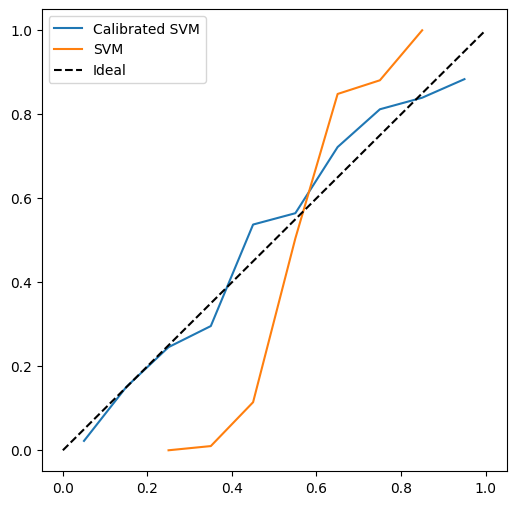

In [82]:
plt.figure(figsize=(6,6))
plot_calibration_curve(y_test, calibrated_svm_pred)
plot_calibration_curve(y_test, svm_pred)
plt.plot(ideal_probs, ideal_probs, linestyle='--', color='black')
plt.legend(['Calibrated SVM', 'SVM', 'Ideal'])
plt.show()

**Вопрос:** Улучшились ли калибровочная кривая и качество калибровки?

**Ответ:** Да, калибровка заняла довольно много времени, но стало сильно лучше. Давайте посмотрим на значения ошибок для обоих вариантов.

In [88]:
print(f'LogLoss    SVM:\t\t  {log_loss(y_test, svm_pred): 0.2f}')
print(f'LogLoss    Calibrated SVM:{log_loss(y_test, calibrated_svm_pred): 0.2f}')

print(f'BrierScore SVM:\t\t  {brier_score_loss(y_test, svm_pred): 0.2f}')
print(f'BrierScore Calibrated SVM:{brier_score_loss(y_test, calibrated_svm_pred): 0.2f}')

LogLoss    SVM:		   0.61
LogLoss    Calibrated SVM: 0.49
BrierScore SVM:		   0.21
BrierScore Calibrated SVM: 0.16


Как мы можем увидеть, качество действительно стало сильно лучше.

# Часть 2. Обработка категориальных переменных (4 балла + 1.5 бонус)

Как мы знаем, перекодировать категориальную переменную в список чисел (к примеру 1, 2, 3, ..., n) плохо, поскольку это бы задало на множестве ее значений некоторый порядок, не имеющий смысла.

В этой части мы рассмотрим два основных способа обработки категориальных значений:
- One-hot-кодирование
- Счётчики (CTR, mean-target кодирование, ...) — каждый категориальный признак заменяется на среднее значение целевой переменной по всем объектам, имеющим одинаковое значение в этом признаке.

Начнём с one-hot-кодирования. Допустим наш категориальный признак $f_j(x)$ принимает значения из множества $C=\{c_1, \dots, c_m\}$. Заменим его на $m$ бинарных признаков $b_1(x), \dots, b_m(x)$, каждый из которых является индикатором одного из возможных категориальных значений:
$$
b_i(x) = [f_j(x) = c_i]
$$

#### __Подготовка данных__

*(бесценный шаг)*

Разберем датасет [покупок велосипедов](https://www.kaggle.com/datasets/heeraldedhia/bike-buyers/): даны признаки покупателя, требуется предсказать, купит ли он/она велосипед



Замените пропуски в категориальных переменных на новую категорию (`'undefined'`)

Разделите признаки на 2 таблицы: категориальные и числовые признаки

In [89]:
# import kagglehub

# path = kagglehub.dataset_download("heeraldedhia/bike-buyers") +  "/bike_buyers.csv"

In [124]:
# Прочитаем датасет
# your code here
df = pd.read_csv('data/bike_buyers.csv')
df.drop('ID', axis=1, inplace=True)

# Отделим X и y
# your code here
X = df.drop(columns=['Purchased Bike'])
y = (df['Purchased Bike'] == 'Yes').astype('int64')

# Разделим на категориальные признаки и числовые
X_numerical = df[list(X.select_dtypes([np.number]).columns)] # your code here
X_categorical = df[list(X.dtypes[X.dtypes == "object"].index)] # your code here

# Заменим пропуски категориальных переменных
# your code here
X_numerical = X_numerical.fillna(0)
X_categorical = X_categorical.fillna('undefined')

In [92]:
X_numerical

,Income,Children,Cars,Age
0,40000.0,1.0,0.0,42.0
1,30000.0,3.0,1.0,43.0
2,80000.0,5.0,2.0,60.0
3,70000.0,0.0,1.0,41.0
4,30000.0,0.0,0.0,36.0
...,...,...,...,...
995,60000.0,2.0,2.0,54.0
996,70000.0,4.0,0.0,35.0
997,60000.0,2.0,0.0,38.0
998,100000.0,3.0,3.0,38.0


В начале поработаем только с категориальными признаками

In [136]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_categorical, y, test_size=0.25, random_state=777, stratify=y)

#### __Задание 3. OrdinalEncoder__  (0.5 балла)

Закодируйте категориальные признаки с помощью `OrdinalEncoder`. Посчитайте качество (в этом задании будем работать c __`AUC-PR`__) при применении логистической регрессии. Замерьте время, потребовавшееся на обучение модели, с учетом кодирования признаков.

In [111]:
import time
from sklearn.metrics import auc
from sklearn.preprocessing import OrdinalEncoder

start = time.time()
encoder = OrdinalEncoder()

X_train_encoded = encoder.fit_transform(X_train)
X_test_encoded = encoder.transform(X_test)

logreg = LogisticRegression()
logreg.fit(X_train_encoded, y_train)

print(f'Time:\t{(time.time() - start ) *100: 0.2f}ms')
logreg_pred = logreg.predict_proba(X_test_encoded)[:,1]

precision, recall, _ = precision_recall_curve(y_test, logreg_pred)
print(f'AUC-PR:\t{auc(recall, precision): 0.2f}')

Time:	 0.87ms
AUC-PR:	 0.58


#### __Задание 4. One-Hot Encoding__ (0.5 балла)



Закодируйте все категориальные признаки с помощью one-hot-кодирования. Обучите логистическую регрессию и посмотрите, как изменилось качество модели (в сравнении с тем, что было до кодирования). Измерьте время, потребовавшееся на кодирование категориальных признаков и обучение модели.

In [110]:
from sklearn.preprocessing import OneHotEncoder
start = time.time()
encoder = OneHotEncoder()

X_train_encoded = encoder.fit_transform(X_train)
X_test_encoded = encoder.transform(X_test)

logreg = LogisticRegression()
logreg.fit(X_train_encoded, y_train)

print(f'Time:\t{(time.time() - start ) *100: 0.2f}ms')
logreg_pred = logreg.predict_proba(X_test_encoded)[:,1]

precision, recall, _ = precision_recall_curve(y_test, logreg_pred)
print(f'AUC-PR:\t{auc(recall, precision): 0.2f}')

Time:	 1.03ms
AUC-PR:	 0.66


Как можно заметить, one-hot-кодирование может сильно увеличивать количество признаков. Это сказывается на объеме необходимой памяти, особенно, если некоторый признак имеет большое количество значений.


#### __Задание 5. Mean-target Encoding__ (1 балл)

> Проблемы разрастания числа признаков можно избежать в другом способе кодирования категориальных признаков — mean-target encoding (для простоты будем называть это __счётчиками__). Сравним эффективность методов в рамках нашей маркетинговой задачи.

> Основная идея в том, что важны не сами категории, а значения целевой переменной, которые имеют объекты этой категории. Каждый категориальный признак мы заменим средним значением целевой переменной по всем объектам этой же категории:

$$
g_j(x, X) = \frac{\sum_{i=1}^{\ell} [f_j(x) = f_j(x_i)][y_i = +1]}{\sum_{i=1}^{\ell} [f_j(x) = f_j(x_i)]}
$$

Закодируйте категориальные переменные с помощью счётчиков (ровно так, как описано выше, без каких-либо хитростей). Обучите логистическую регрессию и посмотрите на качество модели на тестовом множестве.

Сравните время обучения с предыдущими экспериментами (с учетом кодирования признаков).

In [105]:
y

0      0
1      0
2      0
3      1
4      1
      ..
995    1
996    1
997    1
998    0
999    1
Name: Purchased Bike, Length: 1000, dtype: int64

In [115]:
start = time.time()

X_train_encoded = X_train.copy()
X_test_encoded = X_test.copy()

train = pd.concat([X_train_encoded, y_train], axis=1)

for feature in X_categorical.columns:
    mean = train.groupby(feature)['Purchased Bike'].mean()
    X_train_encoded[feature] = X_train_encoded[feature].map(mean)
    X_test_encoded[feature] = X_test_encoded[feature].map(mean)

X_train_encoded = X_train_encoded.astype('float64')
X_test_encoded = X_test_encoded.astype('float64')

logreg = LogisticRegression()
logreg.fit(X_train_encoded, y_train)

print(f'Time:\t{(time.time() - start ) *100: 0.2f}ms')

logreg_pred = logreg.predict_proba(X_test_encoded)[:,1]

precision, recall, _ = precision_recall_curve(y_test, logreg_pred)
print(f'AUC-PR:\t{auc(recall, precision): 0.2f}')

Time:	 1.47ms
AUC-PR:	 0.65


Время обучения выросло, хотя количество признаков значительно снизилось по сравнению с OHE. Качество примерно такое же.

_______

__Методы борьбы с переобучением счетчиков__


Отметим, что mean-target encoding признаки сами по себе являются классификаторами и, обучаясь на них, мы допускаем "утечку" целевой переменной в признаки. Это ведёт к __переобучению__, поэтому считать такие признаки необходимо таким образом, чтобы при вычислении для конкретного объекта его __целевая метка не использовалась__.

Это можно делать следующими способами:
1. Вычислять значение счётчика по всем объектам расположенным выше в датасете (например, если у нас выборка отсортирована по времени).
2. Вычислять по фолдам, то есть делить выборку на некоторое количество частей и подсчитывать значение признаков по всем фолдам кроме текущего (как делается в кросс-валидации).
3. Внесение некоторого шума в посчитанные признаки.

#### __Задание 6. Пошумим__  (0.5 балла)

Реализуйте корректное вычисление счётчиков самым простым способом — добавление шума к значениям.  При этом постарайтесь найти баланс между борьбой с переобучением и сохранением полезности признаков. Снова обучите логистическую регрессию, оцените качество.

In [131]:
from sklearn.preprocessing import TargetEncoder
start = time.time()
encoder = TargetEncoder()


encoder.fit(X_train, y_train)

X_train_encoded = encoder.transform(X_train)
X_test_encoded = encoder.transform(X_test)

noise = 100
X_train_noisy = X_train_encoded.copy()
for feature in range(len(X_train_encoded)):
    X_train_noisy[feature] += np.random.normal(0, noise, len(X_train_noisy[feature]))

logreg = LogisticRegression()
logreg.fit(X_train_encoded, y_train)

print(f'Time:\t{(time.time() - start ) *100: 0.2f}ms')
logreg_pred = logreg.predict_proba(X_test_encoded)[:,1]

precision, recall, _ = precision_recall_curve(y_test, logreg_pred)
print(f'AUC-PR:\t{auc(recall, precision): 0.2f}')

Time:	 1.14ms
AUC-PR:	 0.66


**Вопрос:** Сделайте выводы. Помогло ли добавление шума? Почему?

**Ответ:** Вроде не особо. Получили копейки качества, и немного уменьшили время работы почему-то.

#### __Задание 7. Сглаживание счетчиков__  (1 балл)

> Теперь ответим на следующий вопрос: что будет, если некоторая категория встречается в выборке всего несколько раз? По этой причине производится сглаживание счётчиков. Например, на практике хорошие результаты показывает использование сглаживания средним по всей выборке:
$$
g_j(x, X) = \frac{\sum_{i=1}^{\ell} [f_j(x) = f_j(x_i)][y_i = +1] + C \times \text{global-mean}}{\sum_{i=1}^{\ell} [f_j(x) = f_j(x_i)] + C}
$$
где $\text{global-mean}$ — доля объектов положительного класса в выборке, $C$ — параметр, определяющий степень сглаживания (можно использовать 10 или подобрать для каждого признака свой). Идея в том, что мы "разбавляем" среднее значение по категории глобальным средним значением. И тем меньше, чем большее количество объектов этой категории встречается в выборке.

> Вместо среднего значения целевой переменной для сглаживания можно использовать любое другое значение от 0 до 1 (этот параметр иногда называют $prior$). Можно сделать несколько признаков с разными значениями параметра. На практике в задачах бинарной классификации полезными бывают даже отрицательные значения!

Добавьте сглаживание, описанное выше и повторите эксперименты. Подберите $C$, чтобы качество было лучше, чем при использовании One-Hot-Encoding


In [143]:
start = time.time()

train = pd.concat([X_train, y_train], axis=1)

C = 5
X_new = {}
for feature in X_categorical.columns:
    group = train.groupby(feature)['Purchased Bike']
    X_new[feature] = (group.sum() + C * np.mean(y_train)) / (group.size() + C)

X_train_encoded = X_train.copy()
X_test_encoded = X_test.copy()

for feature in X_categorical.columns:
    mean = X_new[feature]
    X_train_encoded[feature] = X_train_encoded[feature].map(mean)
    X_test_encoded[feature] = X_test_encoded[feature].map(mean)

X_train_encoded = X_train_encoded.astype('float64')
X_test_encoded = X_test_encoded.astype('float64')


logreg = LogisticRegression()
logreg.fit(X_train_encoded, y_train)

print(f'Time:\t{(time.time() - start ) *100: 0.2f}ms')

logreg_pred = logreg.predict_proba(X_test_encoded)[:,1]

precision, recall, _ = precision_recall_curve(y_test, logreg_pred)
print(f'AUC-PR:\t{auc(recall, precision): 0.2f}')

Time:	 1.59ms
AUC-PR:	 0.67


Ура! Мы обыграли OHE.